<a href="https://colab.research.google.com/github/rlaqhalx/machine_learning_study/blob/main/MedAbstractNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The model segments PubMed paper abstracts into five sections to classify sentences by their role, exploring NLP capabilities in sequential sentence classification within RCT abstracts.

I am replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts (
https://arxiv.org/pdf/1710.06071.pdf) and Neural Networks for Joint Sentence Classification in Medical Paper Abstracts (https://arxiv.org/pdf/1612.05251.pdf)

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

My model aims to segment and categorize sentences within abstracts from PubMed papers into five distinct sections: BACKGROUND, OBJECTIVES, METHODS, RESULTS, and CONCLUSIONS. This approach allows for the examination of how natural language processing (NLP) models can accurately classify sentences based on their function and sequence within a randomized controlled trial (RCT) abstract. The overarching goal is to determine the role of each sentence in contributing to the structured summary of an RCT, thereby enhancing understanding and extraction of key information from scientific literature.


In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-87eed1fd-7235-4b39-9744-b43b55a099d8)


# Data Import

In [2]:
# Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


* train.txt - training samples.
* dev.txt - validation set
* test.txt - test samples

In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Data Preprocess


In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()


In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Output for preprocessed sample
```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 740 ms, sys: 137 ms, total: 876 ms
Wall time: 1.84 s


(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


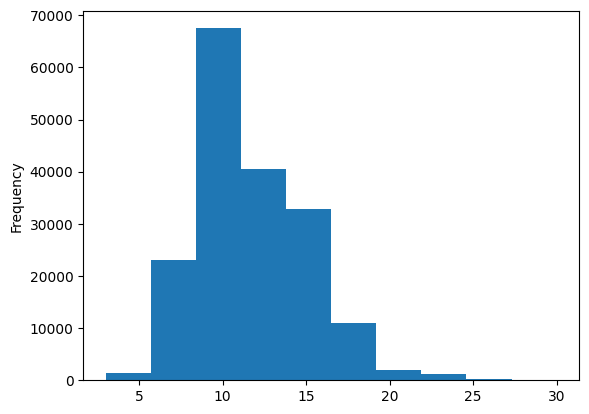

In [12]:
# Distribution of labels in training data
print(train_df.target.value_counts())

# Distribution of our abstract lengths
train_df.total_lines.plot.hist();

## Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the tolist() method on our "text" columns.

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## One-Hot + Label Encoding

 TensorFlow's CategoricalCrossentropy loss function, for instance, expects targets to be one-hot encoded for it to compute the loss correctly, hence allowing for techniques like label smoothing.

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Helper Functions

In [18]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Model 0: TF-IDF Multinomial Naive Bayes (Baseline)



Scikit-Learn Pipeline with **TfidfVectorizer** class to convert our abstract sentences to numbers using the **TF-IDF** (term frequency-inverse document frequecy) algorithm and MultinomialNB algorithm to classify the sentences.


**TfidfVectorizer = CountVectorizer + TfidfTransformer**

A high TF-IDF score: the term has high importance in that particular document and is relatively uncommon across other documents.

A low TF-IDF score: either the term is common across all documents (high IDF, but low TF) or not very important in the particular document (low TF), or both.

**Multinomial Naive Bayes** is a variant of the Naive Bayes algorithm, which is based on Bayes' theorem with the *“naive” assumption of conditional independence* between every pair of features given the value of the class variable.

Training: The classifier learns the probability of each term in the vocabulary appearing in documents belonging to each class. It does this by counting occurrences and then applying smoothing techniques (like Laplace smoothing) to avoid the problem of zero probability for unseen words.

Prediction: For a new document, the classifier computes the probability of the document belonging to each class based on the learned term probabilities. The Naive Bayes assumption simplifies this computation because it allows the model to treat the presence (or count) of each term in the document as independent events. Thus, the probability of the document being in a class is the product of the individual term probabilities (adjusted by the prior probability of the class).

Limitatiobn: Its performance can be limited by the independence assumption, which doesn't hold in many real-world scenarios (words in a sentence are often dependent on each other), and its reliance on frequency counts.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [20]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)

# Calculate baseline results on validation dataset
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
print("baseline result:", baseline_results)

baseline result: {'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1': 0.6989250353450294}


# Preparation for Deep Sequence Model

The vectorization layer will convert our text to numbers.


The embedding layer will capture the relationships between those numbers.

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Since vectorization turns the sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When a model goes through sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

In [22]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

95% of the lengths would be covered by 55 lengths



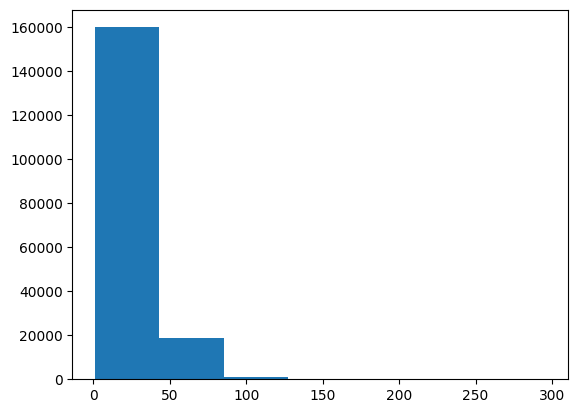

In [23]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);


# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
print("95% of the lengths would be covered by", output_seq_len, "lengths\n")

For the tokenization layer, I will be using this value to turn all of the sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

## Text Vectorization Layer

Text vectorization: the process of converting text into numerical vectors

Most common form:

**Count Vectorization (Bag of Words):** The text is transformed into a vector where each element represents the frequency of a specific word in the text.

**TF-IDF Vectorization (Term Frequency-Inverse Document Frequency):** considering the frequency of words in a document + how unique these words are across all documents in the corpus.



I kept all the parameters default except for max_tokens (the number of unique words in the dataset) and output_sequence_length (the desired output length for each vectorized sentence (55)).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000 (max_tokens parameter).

In [24]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [25]:
# Create text vectorizer

# After TensorFlow 2.6
from tensorflow.keras.layers import TextVectorization

# The most frequent words in the dataset are given lower indices
# Less frequent words might not be included if max_tokens <  total number of unique words
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [26]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [27]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
clarity of recipient stroma , intraocular pressure , and complications were followed for @ months .

Length of text: 16

Vectorized text:
[[ 8498     4  6151 10519  1944   200     3   296     9   284    11    41
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [28]:
# More details about the dataset
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Custom Text Embedding Layer

**trainable embedding matrix**

The token_vectorization layer maps the words in the text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As the model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

___________________________________________________________

The **input_dim parameter** defines the size of the vocabulary.

The **output_dim parameter** defines the dimension of the embedding output.
___________________________________________________________


Once created, the embedding layer will take the integer outputs of the text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

Ability to capture the context of words, semantic similarity, and syntactic relationships.

The most common methods to generate embeddings include:

**Word2Vec and GloVe (Global Vectors for Word Representation)**: Based on their co-occurrence information. Words that appear in similar contexts are given similar vectors, meaning semantically similar words will be closer to each other in the vector space.

**Contextual Embeddings (BERT, ELMO, GPT):** Unlike Word2Vec and GloVe, which generate a single embedding for each word regardless of its context, models like BERT and ELMO produce embeddings that consider the context in which a word appears. This means the same word can have different embeddings based on its surrounding words.

In [30]:
# Create token embedding layer

# With an input of shape (None, 55) and an output dimension of 128,
# this layer creates a 128-dimensional embedding for each of the 55 tokens in each input sequence.

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")


In [31]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
clarity of recipient stroma , intraocular pressure , and complications were followed for @ months .

Sentence after vectorization (before embedding):
[[ 8498     4  6151 10519  1944   200     3   296     9   284    11    41
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.01682261  0.00034766 -0.01930236 ...  0.00214978  0.0274918
    0.04704603]
  [ 0.01987768  0.01042795 -0.02802638 ...  0.0009925   0.03033247
    0.04768703]
  [-0.0161929  -0.01221299 -0.01503452 ... -0.03221258  0.00224467
    0.00887249]
  ...
  [ 0.00143515  0.03209749 -0.01410623 ...  0.02250076 -0.01791556
    0.03628278]
  [ 0.00143515  0.03209749 -0.01410623 ...  0.02250076 -0.01791556
    0.03628278]
  [ 0.00143515  0.03209749 -0.

The shape (1, 55, 128) indicates that the model has processed a single 1 sentence, converting it into a sequence of 55 tokens, each represented by a 128-dimensional embedding vector.

This transformation is a crucial step in many NLP tasks, enabling the model to understand and work with the textual data in a numerical form.

# More Data Preprocess for Tensor Flow

Create datasets as fast as possible

The tf.data API provides methods which enable faster data loading.

📖 Resource:

https://www.tensorflow.org/guide/data
https://www.tensorflow.org/guide/data_performance


Turn the data into a `PrefetchDataset` of batches to ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

`Prefetching` means that while your model is executing training steps on the GPU, the CPU can simultaneously prepare the next batches of data, so the GPU doesn't have to wait for the data to become available.

To create a batched PrefetchDataset, use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [32]:
# Turn the data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with Token Embeddings


Deep model follows a similar structure:

    Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

The main component being changed throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

Workflow:
1. Build model
2. Train model
3. Evaluate model (make predictions and compare to ground truth)

**Summary CNN:**

**Convolutional layers** first identify patterns in sequences of words using filters.

**Pooling layers** then summarize these patterns, reducing the sequence length and focusing on the presence of specific features rather than their exact location in the text.

- max pooling and average pooling

Finally, **Dense layers(fully-connected)** interpret these summarized features to make predictions.

Conv1D vs. Conv2D

Conv1D
- for 1-dimensional data
- filters move across one dimension (length)
- used for sequential data, capturing relationships in one dimension (e.g., across time or sequence position)

Conv2D
- for 2-dimensional data
- filters move across two dimensions (height and width).
- used for spatial data, capturing relationships in two dimensions (e.g., across height and width in an image).


**Activation functions** play a critical role in neural networks by introducing non-linear properties that allow the network to capture complex relationships in the data.

ReLU (hidden layer)

- a piecewise linear function that outputs the input directly if it is positive; otherwise, it will output zero.
- Neurons become either "active" or "inactive" based on their input, allowing the network to construct non-linear decision boundaries.
- Prevents Vanishing Gradient Problem

Softmax (output layer)

- Converts the raw scores (logits) into probabilities and normalizes these values.
- The result is a vector of values that sum up to 1, making it interpretable as a probability distribution.



First model: 1-dimensional Convolutional Neural Network

In [34]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

Based on the model summary,  the majority of the trainable parameters are within the embedding layer.

If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

Before fiting the model to the training data:

Since the training time for data with 200,000 sentences would take a while, I only used the first 10% of the batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [36]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches


Epoch 1/3
562/562 [==============================] - 21s 31ms/step - loss: 0.9191 - accuracy: 0.6362 - val_loss: 0.6855 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6595 - accuracy: 0.7550 - val_loss: 0.6349 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6191 - accuracy: 0.7729 - val_loss: 0.5979 - val_accuracy: 0.7822


In [37]:
# Evaluate on whole validation dataset (Only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5999 - accuracy: 0.7855


[0.5999452471733093, 0.7855156660079956]

In [38]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.44549263e-01, 1.61130726e-01, 7.97776952e-02, 2.84857899e-01,
        2.96844188e-02],
       [4.53723222e-01, 2.56962359e-01, 1.09895775e-02, 2.72790283e-01,
        5.53456647e-03],
       [1.44877449e-01, 8.94076191e-03, 1.73989928e-03, 8.44410956e-01,
        3.08958224e-05],
       ...,
       [4.90136972e-06, 6.08065748e-04, 4.79266309e-04, 1.82739052e-06,
        9.98905897e-01],
       [5.74253760e-02, 4.57977057e-01, 1.02559201e-01, 7.24476129e-02,
        3.09590727e-01],
       [1.54657885e-01, 6.86058640e-01, 4.30140793e-02, 4.37728316e-02,
        7.24965110e-02]], dtype=float32)

In [39]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
# returns: <tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
print(model_1_results)

{'accuracy': 78.55156891301469, 'precision': 0.781969676308642, 'recall': 0.7855156891301469, 'f1': 0.7828543272503279}


# Model 2: Feature extraction with pretrained token embeddings

## Transfer Learning : Feature extraction transfer learning

TensorFlow Hub Pretrained Feature Extractor

Training my own embeddings took a long time to run, so I replicated the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts. It mentions that they used a pretrained GloVe embedding as a way to initialize their token embeddings.

To emulate this, I will use the pretrained Universal Sentence Encoder embedding from TensorFlow Hub.

*GloVe embedding explained in the paper is not available from TensorFlow Hub.*

The model structure will look like:

    Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)


Note that there is no tokenization layer because the USE takes care of tokenization.


I kept the pretrained embeddings frozen (by setting trainable=False) and added a trainable couple of layers on the top to tailor the model outputs to my own data.


In [40]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [41]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
at a @ mm renal calculus size threshold ultralow dose computerized tomography is accurate for detection when referenced against routine low dose series with dose reduction to below the level of a typical @-view plain x-ray ofthekidneys , ureters and bladder .

Sentence after embedding:
[-0.0720075  -0.01916568 -0.06270828 -0.03184916  0.02257302 -0.0487438
 -0.06027824  0.03501621  0.06997832  0.0590659   0.07292995 -0.03729527
 -0.03354834  0.06542752  0.02146833 -0.02642547 -0.07526857  0.07081744
 -0.03156816  0.04640538 -0.06559999  0.04306817 -0.05782564  0.05255053
  0.07058733  0.04273778  0.04552196 -0.02602894 -0.02955466  0.00689685] (truncated output)...

Length of sentence embedding:
512


output: 512 dimensional embedding vector

No Conv1D and Pooling:
- No need for Conv1D layers to capture local contextual relationships followed by pooling to reduce dimensionality
- Because pre-trained embedding layer already capture semantic information, and pooling layers are not strictly necessary to aggregate features.
  


In [42]:
# Building and fitting an NLP feature extraction model from TensorFlow Hub

# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Based on the summary of the model, there is a large number of total parameters but the majority of them are non-trainable. (because of ``training = False``)

So when training this model, only the top two output layers will be trained.

In [44]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9165 - accuracy: 0.6521 - val_loss: 0.7984 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7700 - accuracy: 0.7011 - val_loss: 0.7565 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7546 - accuracy: 0.7102 - val_loss: 0.7406 - val_accuracy: 0.7138


In [45]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7432 - accuracy: 0.7119


[0.743172287940979, 0.7119356393814087]

Note: Since I am not training my own custom embedding layer, training is much quicker.

In [46]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.1885448e-01, 3.6758208e-01, 2.3348161e-03, 2.0319963e-01,
        8.0289757e-03],
       [3.6191341e-01, 4.9214578e-01, 4.4783079e-03, 1.3790968e-01,
        3.5528459e-03],
       [2.2605231e-01, 1.4981858e-01, 1.9923534e-02, 5.6848919e-01,
        3.5716388e-02],
       ...,
       [1.5147381e-03, 6.4571002e-03, 5.4722570e-02, 9.0199889e-04,
        9.3640363e-01],
       [3.7566684e-03, 5.0777931e-02, 1.9963835e-01, 1.4074016e-03,
        7.4441969e-01],
       [1.6646907e-01, 2.2197954e-01, 5.5229604e-01, 4.9055465e-03,
        5.4349784e-02]], dtype=float32)

In [47]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results


{'accuracy': 71.1935654706739,
 'precision': 0.7121364633710172,
 'recall': 0.711935654706739,
 'f1': 0.7088677651622153}

Actually worse than baseline model!

# Model 3: Conv1D with character embeddings

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions a hybrid use of token and character embeddings.

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

To create a character-level embedding,

1: vectorizing the sequences (after they've been split into characters) using the TextVectorization class

2: passing those vectorized sequences through an Embedding layer

In [48]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a t   a   @   m m   r e n a l   c a l c u l u s   s i z e   t h r e s h o l d   u l t r a l o w   d o s e   c o m p u t e r i z e d   t o m o g r a p h y   i s   a c c u r a t e   f o r   d e t e c t i o n   w h e n   r e f e r e n c e d   a g a i n s t   r o u t i n e   l o w   d o s e   s e r i e s   w i t h   d o s e   r e d u c t i o n   t o   b e l o w   t h e   l e v e l   o f   a   t y p i c a l   @ - v i e w   p l a i n   x - r a y   o f t h e k i d n e y s   ,   u r e t e r s   a n d   b l a d d e r   .'

In [49]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long the vectorized character sequences should be, need to check the distribution of the character sequence lengths.



In [50]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

290


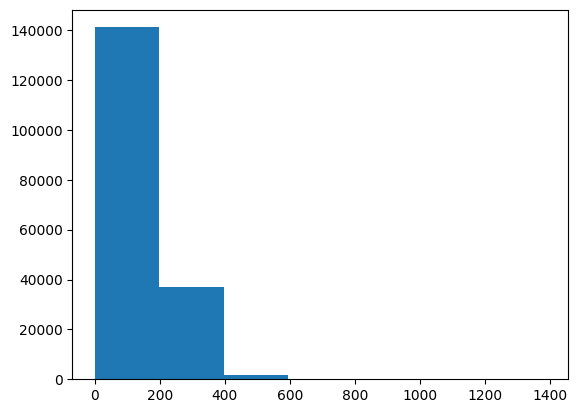

In [51]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
print(output_seq_char_len)

In [52]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [53]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [54]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
m i x e d - e f f e c t s   m o d e l s   a n d   m u l t i v a r i a t e   l o g i s t i c   r e g r e s s i o n   w e r e   u s e d   i n   t h e   a n a l y s i s   .

Length of chars: 74

Vectorized chars:
[[15  4 24  2 10  2 17 17  2 11  3  9 15  7 10  2 12  9  5  6 10 15 16 12
   3  4 21  5  8  4  5  3  2 12  7 18  4  9  3  4 11  8  2 18  8  2  9  9
   4  7  6 20  2  8  2 16  9  2 10  4  6  3 13  2  5  6  5 12 19  9  4  9
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

Note that sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, which ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

## Creating a character-level embedding
After vectorizing the character-level sequences, its time to create a character-level embedding using the `tensorflow.keras.layers.Embedding class`

Character-level embedding layer requires an input dimension and output dimension.

The input dimension (input_dim) will be equal to the number of different characters in char_vocab (28). And since I am following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.



In [55]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
m i x e d - e f f e c t s   m o d e l s   a n d   m u l t i v a r i a t e   l o g i s t i c   r e g r e s s i o n   w e r e   u s e d   i n   t h e   a n a l y s i s   .

Embedded chars (after vectorization and embedding):
[[[ 0.0398039   0.04678878 -0.00447327 ... -0.03884666 -0.03928261
    0.0162501 ]
  [ 0.02423865  0.01654204  0.03701052 ... -0.03353913 -0.03644122
   -0.01896711]
  [ 0.00838938 -0.00436735 -0.00447545 ...  0.03864424  0.00524254
    0.02949044]
  ...
  [ 0.00729467  0.0374863   0.04994247 ...  0.01844138  0.04403595
   -0.03207178]
  [ 0.00729467  0.0374863   0.04994247 ...  0.01844138  0.04403595
   -0.03207178]
  [ 0.00729467  0.0374863   0.04994247 ...  0.01844138  0.04403595
   -0.03207178]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings

In [56]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

## char-level batched PrefetchedDataset's

Before fitting the model, prefetch for the optimization and run time improvement


In [58]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Fit the model

In [59]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2499 - accuracy: 0.4980 - val_loss: 1.0131 - val_accuracy: 0.6047
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9844 - accuracy: 0.6134 - val_loss: 0.9213 - val_accuracy: 0.6340
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9134 - accuracy: 0.6432 - val_loss: 0.8530 - val_accuracy: 0.6622


In [60]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8727 - accuracy: 0.6589


[0.8726670742034912, 0.6588772535324097]

In [61]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.15111138, 0.28322175, 0.20526727, 0.3304064 , 0.0299932 ],
       [0.2589381 , 0.387801  , 0.00546673, 0.32534733, 0.02244691],
       [0.08712222, 0.0986058 , 0.23080596, 0.54327494, 0.04019113],
       ...,
       [0.01626832, 0.04230898, 0.04839339, 0.01459686, 0.87843245],
       [0.03106122, 0.06043052, 0.6670261 , 0.0730395 , 0.1684427 ],
       [0.5457942 , 0.3043796 , 0.06523003, 0.07690366, 0.00769257]],
      dtype=float32)

In [62]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.88772673110023,
 'precision': 0.6527146166804367,
 'recall': 0.6588772673110023,
 'f1': 0.6484083500777165}

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)


 Below builds a hybrid model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts.

 This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

## Token-character hybrid model

**LSTM (Long Short-Term Memory)**

LSTM units are a type of recurrent neural network (RNN) architecture that are particularly good at capturing long-term dependencies in sequence data, addressing the vanishing gradient problem common in traditional RNNs.


**Bi-LSTM Layer:**

A bidirectional LSTM (Bi-LSTM) layer processes the character embeddings. Bi-LSTM layers can capture dependencies in the input sequence both forwards and backwards, providing a comprehensive understanding of the character-level sequence.

In neural networks performing classification, the number of output units typically corresponds to the number of categories (or classes) we want to predict. Each unit's output represents the model's confidence that the input belongs to one of the classes

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [63]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
# number of output units (num_classes) corresponds to the number of classes in the classification task.
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [64]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

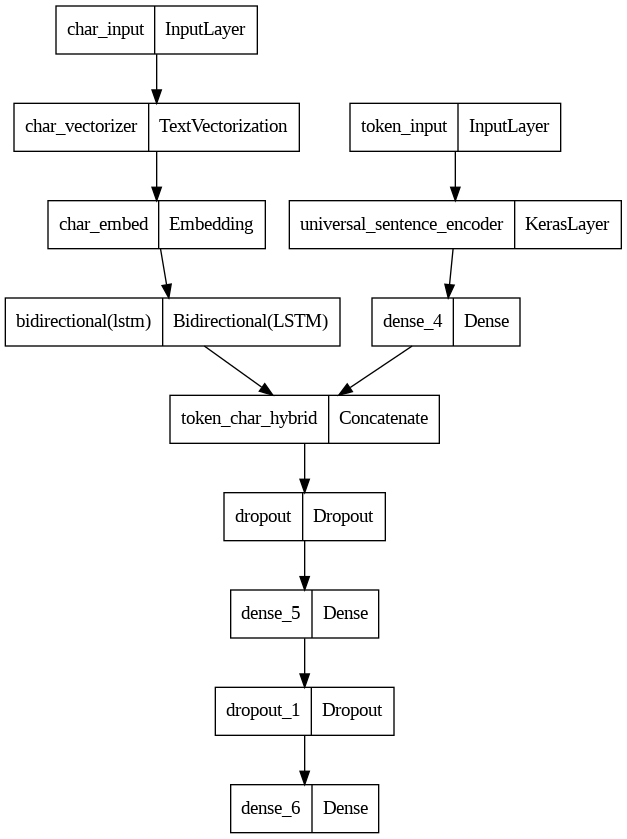

In [65]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

Note: Section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts mentions using the SGD (stochastic gradient descent) optimizer, however, to stay consistent with the other models, I am going to use the Adam optimizer.

In [66]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Combining token and character data into a tf.data dataset

This model requires two inputs, token-level sequences and character-level sequences so I created a tf.data.Dataset with a tuple as it's first input, for example:

((token_data, char_data), (label))

In [67]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting a model on token and character-level sequences

In [69]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 38ms/step - loss: 0.9723 - accuracy: 0.6132 - val_loss: 0.7781 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7835 - accuracy: 0.6982 - val_loss: 0.7118 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7654 - accuracy: 0.7049 - val_loss: 0.6917 - val_accuracy: 0.7404


In [70]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 20ms/step - loss: 0.6936 - accuracy: 0.7350


[0.6936485171318054, 0.7350059747695923]

To make predictions with it, since it takes multiplie inputs, we can pass the predict() method a tuple of token-level sequences and character-level sequences.

In [71]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs


945/945 [==============================] - 19s 19ms/step


array([[4.10941809e-01, 3.49952877e-01, 3.38799157e-03, 2.26302132e-01,
        9.41512082e-03],
       [3.69808823e-01, 3.33826929e-01, 2.01284583e-03, 2.92962372e-01,
        1.38900860e-03],
       [3.06928009e-01, 1.01851486e-01, 4.83833402e-02, 5.07665157e-01,
        3.51719931e-02],
       ...,
       [8.03871779e-04, 1.03949700e-02, 6.98888972e-02, 2.92035984e-04,
        9.18620169e-01],
       [5.99753112e-03, 5.67837656e-02, 1.97453529e-01, 2.66451691e-03,
        7.37100661e-01],
       [2.27635071e-01, 3.80695999e-01, 2.97438979e-01, 3.14238109e-02,
        6.28061220e-02]], dtype=float32)

In [73]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [75]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results


{'accuracy': 73.50059578975242,
 'precision': 0.7355924183163252,
 'recall': 0.7350059578975242,
 'f1': 0.7324213238360981}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

Feature Engineering: The process of applying your own knowledge to build features as input to a model



The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding

We can use these features because they will be available at test time.



## Create positional embeddings

To avoid numerical hierarchy (a line with "line_number"=5 is five times greater than a line with "line_number"=1), I'll use `one-hot-encoding `to encode our "line_number" and "total_lines" features.

To do this, we can use the `tf.one_hot` utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

### Line_number

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64


<Axes: ylabel='Frequency'>

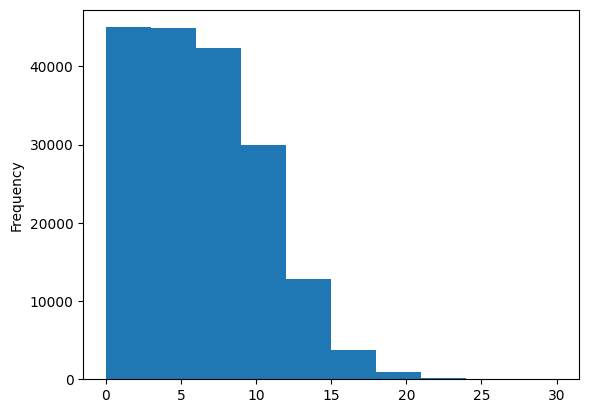

In [76]:
# How many different line numbers are there?
print(train_df["line_number"].value_counts())

# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less. So set the depth parameter of tf.one_hot to 15.

In [77]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

To avoid curse of dimensionality:

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.



### Total_line

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64


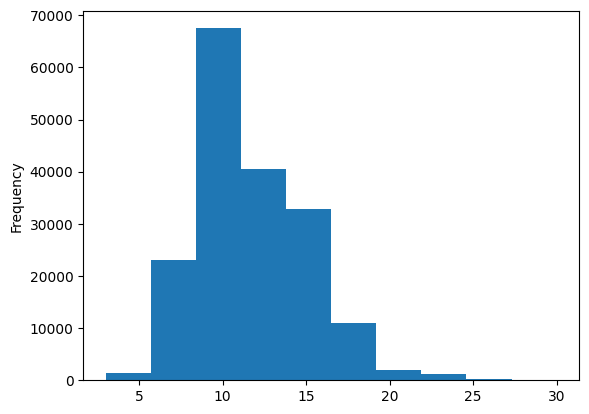

In [78]:
# How many different numbers of lines are there?
print(train_df["total_lines"].value_counts())

# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [79]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [80]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building a tribrid embedding model


1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a `"line_number"` model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [81]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [82]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

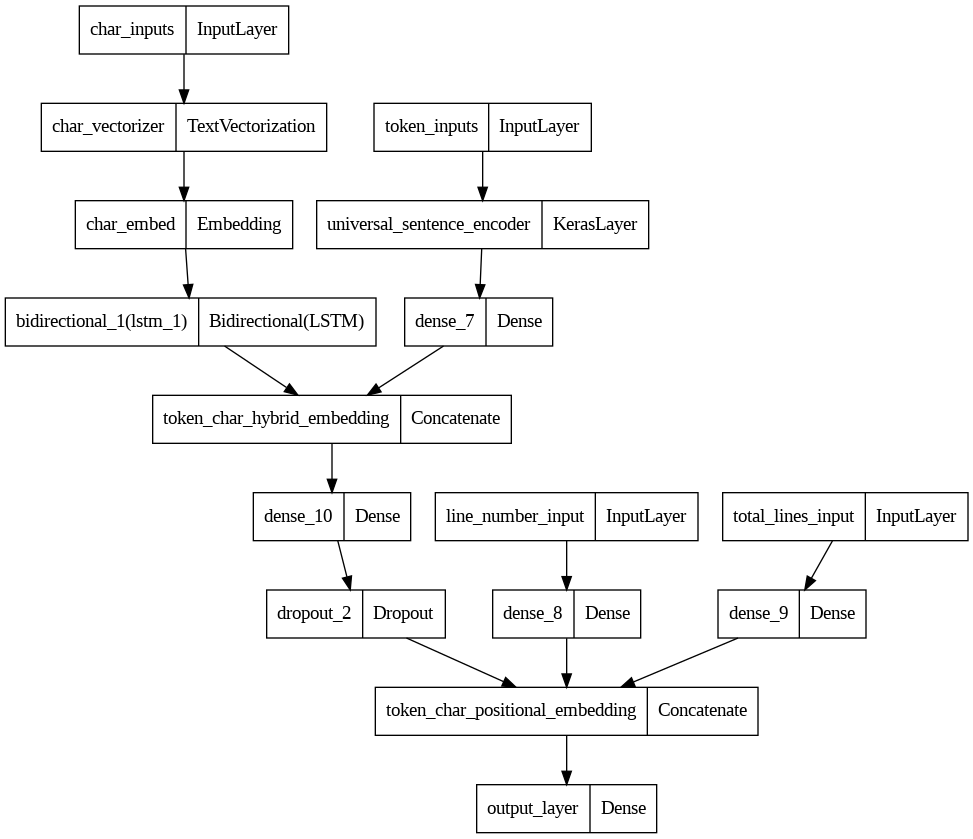

In [83]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Trying to encode as much information about the sequences as possible into various embeddings (the inputs to our model) so this model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

This model is very similar to the model shown in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts except for a few differences:

1. used pretrained TensorFlow Hub token embeddings instead of GloVe emebddings
2. used a Dense layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
3. Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it isn't shown in Figure 1. To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
4. Section 4.2 of the paper mentions the token and character embeddings are updated during training, but pretrained TensorFlow Hub embeddings remain frozen.
5. Used Adam instead of SGD optimizer

In [84]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7e26d8546ce0> True
<keras.src.engine.input_layer.InputLayer object at 0x7e2665a0a7d0> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7e25d544fc10> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7e26e036bac0> False
<keras.src.layers.core.embedding.Embedding object at 0x7e25d54216f0> True
<keras.src.layers.core.dense.Dense object at 0x7e273dcc2d70> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7e25c8f061a0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7e26d8521a80> True
<keras.src.engine.input_layer.InputLayer object at 0x7e25c8f05930> True
<keras.src.engine.input_layer.InputLayer object at 0x7e2665b527a0> True
<keras.src.layers.core.dense.Dense object at 0x7e26e29dc190> True
<keras.src.layers.core.dense.Dense object at 0x7e26e2b57a90> True
<keras.src.layers.core.dense.Dense object at 0x7e2665b98550> True
<keras.src.layers.regularization.dropout.

Loss function: `label_smoothing`.

Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

In [85]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create tribrid embedding datasets

This time, model 5 requires four feature inputs:

1. Train line numbers one-hot tensor `(train_line_numbers_one_hot)`
2. Train total lines one-hot tensor `(train_total_lines_one_hot)`
3. Token-level sequences tensor `(train_sentences)`
4. Char-level sequences tensor `(train_chars)`

We can pass these as tuples to our tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [86]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fit tribrid model

In [87]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 28s 39ms/step - loss: 1.0975 - accuracy: 0.7220 - val_loss: 0.9877 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9678 - accuracy: 0.8169 - val_loss: 0.9494 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9510 - accuracy: 0.8231 - val_loss: 0.9397 - val_accuracy: 0.8298


In [88]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 20s 20ms/step


array([[0.49653098, 0.10550335, 0.01035474, 0.36643276, 0.02117815],
       [0.51625335, 0.10726311, 0.04611041, 0.31910348, 0.01126961],
       [0.31592447, 0.11181724, 0.14942244, 0.353394  , 0.06944188],
       ...,
       [0.04334284, 0.099259  , 0.03783489, 0.03403543, 0.7855279 ],
       [0.02851102, 0.28589374, 0.07522058, 0.0237275 , 0.58664715],
       [0.22455794, 0.5874035 , 0.09718078, 0.03589951, 0.0549583 ]],
      dtype=float32)

In [89]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds


# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.20865881106845,
 'precision': 0.8310778834588983,
 'recall': 0.8320865881106845,
 'f1': 0.8311453296541682}

# Compare model results


In [90]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.551569,0.781970,0.785516,0.782854
pretrained_token_embed,71.193565,0.712136,0.711936,0.708868
custom_char_embed_conv1d,65.887727,0.652715,0.658877,0.648408
hybrid_char_token_embed,73.500596,0.735592,0.735006,0.732421
tribrid_pos_char_token_embed,83.208659,0.831078,0.832087,0.831145


In [91]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

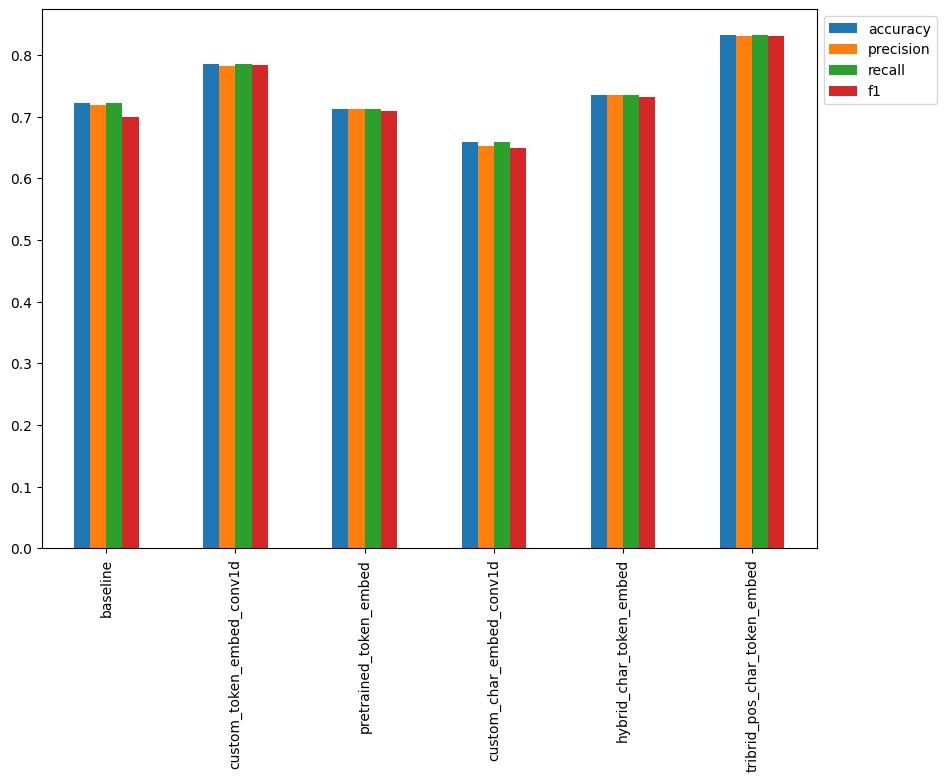

In [92]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

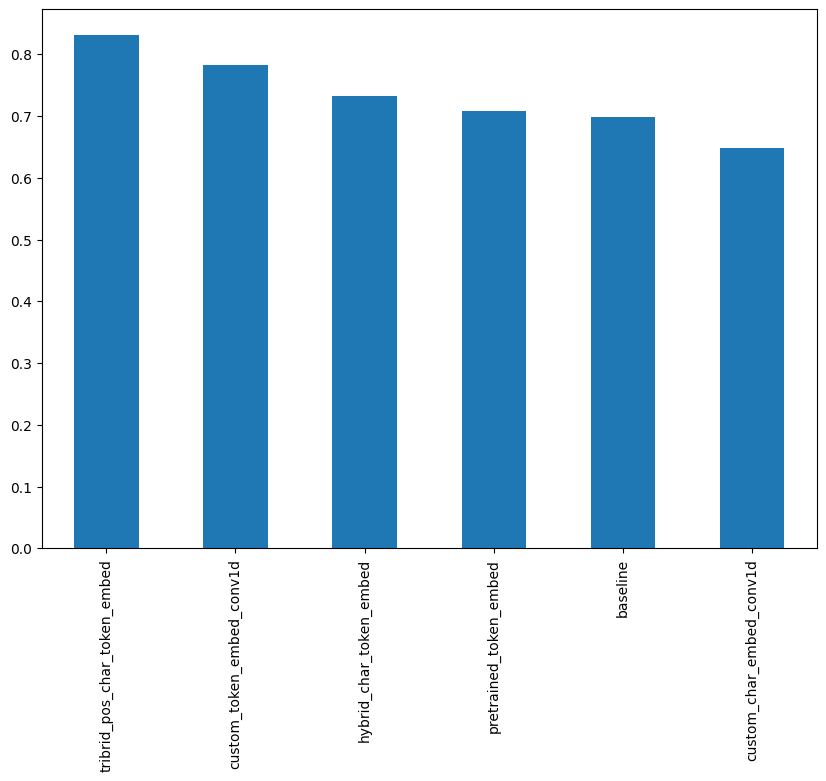

In [93]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, my model's F1-score is underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6)

My models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.


# Evaluate model on test dataset

In [94]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [95]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 17s 18ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [96]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.70781483325037,
 'precision': 0.8257123118197536,
 'recall': 0.8270781483325037,
 'f1': 0.8260615917632043}